<a href="https://colab.research.google.com/github/Trushali29/Artificial-Intelligence-In-Agritculture/blob/main/LeafClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.Vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
# unzip the dataset
#!unzip "/content/drive/MyDrive/PlantVillage_Dataset.zip" -d "/content/drive/MyDrive/"

In [ ]:
#image input size 
IMAGE_SIZE = [224,224]
#providing paths to train and test dataset
train_path ='/content/drive/MyDrive/PlantVillage_Dataset/train' 
valid_path = '/content/drive/MyDrive/PlantVillage_Dataset/validate'

In [ ]:
#download inception weights
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
  layer.trainable = False 

In [ ]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/PlantVillage_Dataset/train/*')

In [ ]:
x = Flatten()(inception.output)
x = Dense(500, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# tell the model what cost function and optimization method to use
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
# use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
validate_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/PlantVillage_Dataset/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9600 images belonging to 10 classes.


In [ ]:
validate_set = validate_datagen.flow_from_directory('/content/drive/MyDrive/PlantVillage_Dataset/validate',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1602 images belonging to 10 classes.


In [ ]:
# fit the model
r = model.fit(
  training_set,
  validation_data=validate_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validate_set)
)

Epoch 1/15
300/300 [==============================] - 3811s 13s/step - loss: 1.7189 - accuracy: 0.8347 - val_loss: 0.2296 - val_accuracy: 0.9251
Epoch 2/15
300/300 [==============================] - 1122s 4s/step - loss: 0.2294 - accuracy: 0.9269 - val_loss: 0.1968 - val_accuracy: 0.9376
Epoch 3/15
300/300 [==============================] - 1198s 4s/step - loss: 0.1874 - accuracy: 0.9405 - val_loss: 0.2360 - val_accuracy: 0.9419
Epoch 4/15
300/300 [==============================] - 1194s 4s/step - loss: 0.1544 - accuracy: 0.9516 - val_loss: 0.1990 - val_accuracy: 0.9326
Epoch 5/15
300/300 [==============================] - 1116s 4s/step - loss: 0.1247 - accuracy: 0.9607 - val_loss: 0.2313 - val_accuracy: 0.9326
Epoch 6/15
300/300 [==============================] - 1121s 4s/step - loss: 0.1176 - accuracy: 0.9624 - val_loss: 0.1429 - val_accuracy: 0.9538
Epoch 7/15
300/300 [==============================] - 1123s 4s/step - loss: 0.1223 - accuracy: 0.9578 - val_loss: 0.1891 - val_accuracy

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_inception.h5')

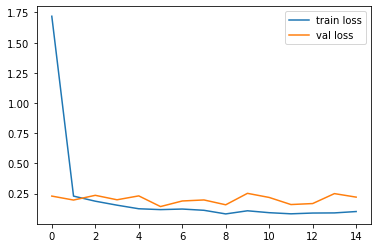

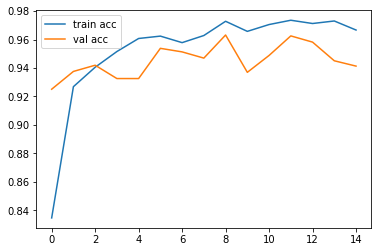

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model
MODEL_PATH = 'model_inception.h5'

#load your trained model
model = load_model(MODEL_PATH)

In [ ]:
import matplotlib.image as mpimg

def model_predict(img_path, model):
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocessing the image
    x = image.img_to_array(img)
    ## Scaling
    x=x/255
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    preds=np.argmax(preds, axis=1)
    if preds==0:
        preds="The leaf is a diseased Apple leaf."
    elif preds==1:
        preds="The leaf is a healthy Apple leaf."
    elif preds==2:
        preds="The leaf is a diseased Cherry leaf."
    elif preds==3:
        preds="The leaf is a healthy Cherry leaf."
    elif preds==4:
        preds="The leaf is a diseased Corn leaf."
    elif preds==5:
        preds="The leaf is a healthy Corn leaf."
    elif preds==6:
        preds="The leaf is a diseased Pepper leaf."
    elif preds==7:
        preds="The leaf is a healthy Pepper leaf."
    elif preds==8:
        preds="The leaf is a diseased Tomato leaf."
    else:
        preds="The leaf is a healthy Tomato leaf."
    
    return preds

In [ ]:
def outcome_and_image(img_path,model):
  result = model_predict(img_path,model)
  img = mpimg.imread(img_path)
  print('')
  return plt.imshow(img),result

/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_diseased_leaf/fee69dd9-eeb1-4cf2-b249-17482605f1f7___FREC_Pwd.M 4689.JPG

Result: The leaf is a diseased Corn leaf.


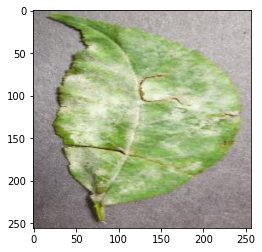

In [ ]:
# diseased cherry leaf
img_path='/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_diseased_leaf/fee69dd9-eeb1-4cf2-b249-17482605f1f7___FREC_Pwd.M 4689.JPG'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_healthy_leaf/bfed28c4-5ef8-4a35-b826-612875cc6b86___JR_HL 4099.JPG

Result: The leaf is a diseased Corn leaf.


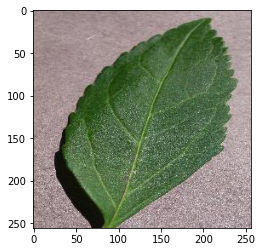

In [ ]:
# healthy cherry leaf
img_path='/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_healthy_leaf/bfed28c4-5ef8-4a35-b826-612875cc6b86___JR_HL 4099.JPG'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_diseased_leaf/e2baac0d-0b5c-4e1d-90d9-70a8d6a6855b___JR_B.Spot 9015.JPG

Result: The leaf is a healthy Tomato leaf.


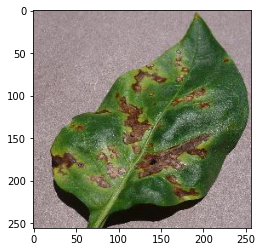

In [ ]:
# diseased pepper leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_diseased_leaf/e2baac0d-0b5c-4e1d-90d9-70a8d6a6855b___JR_B.Spot 9015.JPG'
im, output = outcome_and_image(img_path, model)
im    
print(f'Result: {output}')

In [ ]:
# healthy pepper leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_healthy_leaf/f6202c30-deb0-498d-8e49-44b012204547___JR_HL 8127.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_healthy_leaf/f6202c30-deb0-498d-8e49-44b012204547___JR_HL 8127.jpg


FileNotFoundError: ignored

In [ ]:
# healthy apple leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_healthy_leaf/fb5116a2-272b-49af-9c27-9b117376a306___RS_HL 8021.jpg'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_healthy_leaf/fb5116a2-272b-49af-9c27-9b117376a306___RS_HL 8021.jpg


FileNotFoundError: ignored

In [ ]:
# diseased apple leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_diseased_leaf/fc2bb6fc-6480-486c-8727-fbd2da59baa4__JR_FrgE.S 8634.JPG'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_diseased_leaf/fc2bb6fc-6480-486c-8727-fbd2da59baa4__JR_FrgE.S 8634.JPG


FileNotFoundError: ignored